In [1]:
import sys
import os, json
import operator

from math import *
import inspect
import numpy as np
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
import handcalcs.render
from handcalcs.decorator import handcalc
import forallpeople as si
from IPython.display import display, Latex


sys.path.append(os.path.join(os.getcwd(), "catalog", "eurocode"))
import A0_Projet as A0
import A1_MEF as A1
import EC0_Combinaison as EC0
import EC5_Assemblage as EC5_Ass
import EC5_Element_droit as EC5_Ele

CONFIG_FILE = '.config_ipynb'
if os.path.isfile(CONFIG_FILE):
    with open(CONFIG_FILE) as json_file:
        json_args = json.load(json_file)

# N° projet - Projet - Note de calcul
---
## Élément :
- Annexe : ANxx
- Date : 03/10/2022
- Ingénieur : Anthony PARISOT
---

## 1. Paramètres
----

- <font color="blue" size ="4">**Vérifications**</font>

In [2]:
ELU_STR = True
ELU_STR_ACC = False
ELS = True

- <font color="blue" size ="4">**Chargement**</font>

In [3]:
Charge1 = [1, '', 'Permanente G', 'Linéique', -370*0.12, '0/7000', 'Z']
Charge2 = [0, 'Poids propre', 'Permanente G', 'Linéique', -111.4*0.12, '0/7000', 'Z']
Charge3 = [2, '', 'Neige normale Sn', 'Linéique', -150*0.12, '0/7000', 'Z']
Charge4 = [3, '', 'Exploitation Q', 'Linéique', -400*0.12, '0/7000', 'Z']

In [4]:
_list_loads = [Charge1, Charge2,Charge3, Charge4]
pd.DataFrame(_list_loads, columns=["Index", "Nom","Action","Type","Charge (daN ou daN/m)","Position (mm)","Axe"])

,Index,Nom,Action,Type,Charge (daN ou daN/m),Position (mm),Axe
0,1,,Permanente G,Linéique,-44.400,0/7000,Z
1,0,Poids propre,Permanente G,Linéique,-13.368,0/7000,Z
2,2,,Neige normale Sn,Linéique,-18.000,0/7000,Z
3,3,,Exploitation Q,Linéique,-48.000,0/7000,Z


- <font color="blue" size ="4">**Appuis**</font>

In [5]:
listdeplacement = [[1, "Rotule", 0, 40], [2, "Rotule", 7000, 40]]

In [6]:
pd.DataFrame(listdeplacement, columns=["Index","Type d'appuis","Position (mm)","Largeur d'appuis (mm)"])

,Index,Type d'appuis,Position (mm),Largeur d'appuis (mm)
0,1,Rotule,0,40
1,2,Rotule,7000,40


- <font color="blue" size ="4">**Dalle**</font>

In [7]:
# app = QApplication()
# disposition, ok = QInputDialog.getItem(
#     None, "Position des planches", "Position des planches :", ["Latérale", "Dessus / Dessous"], 0, False, flags=Qt.FramelessWindowHint)

# type_batiment, ok = QInputDialog.getItem(
#     None, "Type de bâtiment", "Type de bâtiment :", ["Bâtiments courants", "Bâtiments agricoles et similaires"], 0, False, flags=Qt.FramelessWindowHint)

In [8]:
#recouvrement (int):Cela correspond à la distance entre le centre géométrique de la pièce 2 et celui de la pièce i. ATTENTION z local est vers le bas quand vous donnez le recouvrement.
#disposition : Correspond à la position des planches ["Latérale", "Dessus / Dessous"]
#Type de bâtiment :["Bâtiments courants", "Bâtiments agricoles et similaires"]

In [9]:
%%render params 2
code_INSEE = 73215
alt = 1200 #m
type_element = "Élément structuraux"
type_batiment = "Bâtiments courants"
categorie_batiment = "Cat A : habitation"
longueur = 7000 * si.mm
disposition = "Latérale"
classe_service = 1
humidite_initiale = 12 #pourcent
humidite_finale = 12 #pourcent
recouvrement = 180 #mm
entraxe_connecteurs = 200 #
deversement = False
flambement_y = False
flambement_z = False

<IPython.core.display.Latex object>

In [10]:
if deversement:
    deversement = longueur.value*10**3
else:
    deversement = 0
if flambement_y:
    flambement_y = longueur.value*10**3
else:
    flambement_y = 0
if flambement_z:
    flambement_z = longueur.value*10**3
else:
    flambement_z = 0

In [11]:
def calcs_number_node(long):
        """Retourne le nombre de d'élément pour le maillage MEF

        Returns:
            int: nombre d'élément MEF
        """
        round_long = ceil(long/10)*10
        
        if round_long <= 1000:
            ele = int(round_long/10)
        elif round_long <= 10000:
            ele = int(round_long/100)
        else:
            ele = int(round_long/200)
        return ele
    
# node = 700
node = calcs_number_node(longueur.value*10**3)

- <font color="blue" size ="4">**Planche basse**</font>

In [12]:
%%render params 2
b_planche_basse = 60 * si.mm
h_planche_basse = 260 * si.mm
classe_bois_planche_basse = "C24"


<IPython.core.display.Latex object>

In [13]:
projet = A0.Projet(code_INSEE=code_INSEE, alt= alt)
chargement = EC0.Chargement._from_parent_class(projet)
chargement.create_load_by_list(_list_loads)
barre2 = EC5_Ass.Barre._from_parent_class(projet, b=b_planche_basse.value*10**3, h=h_planche_basse.value*10**3, section="Rectangulaire", Hi=humidite_initiale, Hf=humidite_finale, classe=classe_bois_planche_basse, cs=classe_service, effet_systeme="False")
pd.DataFrame(barre2.caract_meca).T

,fm0k,ft0k,ft90k,fc0k,fc90k,fvk,E0mean,E005,E90mean,Gmoy,rhok,rhomean
C24,24,14.5,0.4,21,2.5,4,11000,7400,370,690,350,420


- <font color="blue" size ="4">**Planche haute**</font>

In [14]:
%%render params 2
b_planche_intermediaire = 60 * si.mm
h_planche_intermediaire = 260 * si.mm
classe_bois_planche_intermediaire = "C24"

<IPython.core.display.Latex object>

In [15]:
barre3 = EC5_Ass.Barre._from_parent_class(projet, b=b_planche_intermediaire.value*10**3, h=h_planche_intermediaire.value*10**3, section="Rectangulaire", Hi=humidite_initiale, Hf=humidite_finale, classe=classe_bois_planche_intermediaire, cs=classe_service, effet_systeme="False")
pd.DataFrame(barre3.caract_meca).T

,fm0k,ft0k,ft90k,fc0k,fc90k,fvk,E0mean,E005,E90mean,Gmoy,rhok,rhomean
C24,24,14.5,0.4,21,2.5,4,11000,7400,370,690,350,420


- <font color="blue" size ="4">**Connecteurs**</font>

In [16]:
%%render params 2
d = 6 * si.mm
d1 = 3.9 * si.mm
ds = 4.3 * si.mm
dh = 12 * si.mm
l = 200 * si.mm
rho_a = 350 * si.kg / si.m**3
fhead = 10.5 * si.MPa
ftensk = 11300 * si.N
f_ax_k = 11.7 *si.MPa
MyRk = 9494 * si.N*si.mm
alpha1 = 90 #°
alpha2 = 90 #°

<IPython.core.display.Latex object>

In [17]:

assemblage = EC5_Ass.Assemblage._from_parent_class(projet, beam_1=barre3, beam_2=barre2, nfile=1, nCis=1)

#############   Vérification vis-boulon ou vis-pointe selon d_ef
if d1.value*10**3*1.1 > 6:
    connecteur = EC5_Ass.Tirefond_sup_6._from_parent_class(assemblage, d=d.value*10**3, d1=d1.value*10**3, ds=ds.value*10**3, dh=dh.value*10**3, l=l.value*10**3, n=1, rho_a=rho_a.value, fhead=fhead.value*10**-6, ftensk=ftensk.value, MyRk=MyRk.value*10**3, alpha1=alpha1, alpha2=alpha2)
else:
    connecteur = EC5_Ass.Tirefond_inf_7._from_parent_class(assemblage, d=d.value*10**3, d1=d1.value*10**3, ds=ds.value*10**3, dh=dh.value*10**3, l=l.value*10**3, n=1, rho_a=rho_a.value, fhead=fhead.value*10**-6, ftensk=ftensk.value, MyRk=MyRk.value*10**3, alpha1=alpha1, alpha2=alpha2, percage = True)



#############   Kser assemblage
Kser_ass = connecteur.Kser_ass
dalle_ELU = EC5_Ele.Poutre_assemblee_meca(beam_2=barre2, l=longueur.value*10**3, disposition=disposition, recouvrement=[0,recouvrement], Ki=[None,None,2/3*Kser_ass[1].value*10**-3], entraxe=[None,None,entraxe_connecteurs], psy_2=0, beam_3=barre3)
combinaison = A1.Combinaison._from_parent_class(chargement, ELU_STR=ELU_STR, ELU_STR_ACC=ELU_STR_ACC, ELS_C=ELS, ELS_QP=ELS, cat=categorie_batiment, kdef=dalle_ELU.K_def[1], type_psy_2= "Long terme")

#############   Nombre efficace
nef = connecteur.nef(a1_beam1=entraxe_connecteurs, a1_beam2=entraxe_connecteurs)

#############   Résistance axiale
FaxRk = connecteur.FaxRk(faxk=f_ax_k, l_ef=connecteur.t1, alpha=alpha1, beam=barre3)

#############   Capacité résistante caractéristique par tige et par plan de cisaillement
FvRk = connecteur.FvRk(True)


l = int(ceil(dalle_ELU.l.value * 10**3))
E_mean = int(barre2.E_mean_fin.value*10**-6)
A = barre2.b * barre2.h + barre3.b * barre3.h
A = A.value*10**6
G = float(barre2.caract_meca.Gmoy)

dict_combi = {}
dict_taux_max = {type_verif: {"combinaison": "", "taux": 0} for type_verif in ("flexion", "cisaillement", "Winst(Q)", "Wnet,fin")}      
        
for combi in combinaison.get_list_combination():
    combinaison.get_combi_list_load(combi)
    dict_combi[combi]= {"planche haute": {}, "planche intermédiaire/basse": {}}
    if combi[0:3] == 'ELU':
        dalle = dalle_ELU
        iy = dalle_ELU.EI_eff[1].value*10**6 / E_mean
    else : 
        dalle_ELS = EC5_Ele.Poutre_assemblee_meca(beam_2=barre2, l=longueur.value*10**3, disposition=disposition, recouvrement=[0,recouvrement], Ki=[None,None,Kser_ass[1].value*10**-3], entraxe=[None,None,entraxe_connecteurs], psy_2=0, beam_3=barre3)
        if combi[0:6] == 'ELS_QP' or combi[0:9] == 'W_net_fin':
            dalle_ELS = EC5_Ele.Poutre_assemblee_meca(beam_2=barre2, l=longueur.value*10**3, disposition=disposition, recouvrement=[0,recouvrement], Ki=[None,None,Kser_ass[1].value*10**-3], entraxe=[None,None,entraxe_connecteurs], psy_2=1, beam_3=barre3)
        E_mean_fin = int(barre2.E_mean_fin.value*10**-6)
        print("E_mean_fin", E_mean_fin, combi)
        dalle = dalle_ELS
        iy = dalle_ELS.EI_eff[1].value*10**6 / E_mean_fin
    dict_combi[combi]["EF"] = A1.MEF._from_parent_class(combinaison, long=l, E=E_mean, A=A, G=G, J=1, Iy=iy, Iz=1, ele=node, alphaZ=0, alphaY=0, alphaX=0)
    dict_combi[combi]["EF"].create_supports_by_list(listdeplacement)
    dict_combi[combi]["EF"].calcul_1D()
    dict_combi[combi]["EF"]

    for i, barre in enumerate([barre2,barre3]):
        index_barre = i+2
        if i==0:
            dim_barre = "planche haute"
        else:
            dim_barre = "planche intermédiaire/basse"
        
        if combi[0:7] == 'ELU_STR':
            action = dict_combi[combi]["EF"].min_type_load(combi)
            barre2.K_mod = barre2.K_mod_table[action].iloc[0]
            barre3.K_mod = barre3.K_mod_table[action].iloc[0]

            dictEiMinMax = dict_combi[combi]["EF"].effort_interne_max()
            max_XY_values = (dictEiMinMax["My_max"]["Position"], dictEiMinMax["My_max"]["Effort"])
            min_XY_values = (dictEiMinMax["My_min"]["Position"], dictEiMinMax["My_min"]["Effort"])
                
            dict_effort_max = dict_combi[combi]["EF"].effort_interne_max()
            V_z = max(dict_effort_max['Vz_max']['Effort'],abs(dict_effort_max['Vz_min']['Effort']))
            tau_2 = dalle.tau_2_max(V_z)

            M_y = max(dict_effort_max['My_max']['Effort'],abs(dict_effort_max['My_min']['Effort']))
            sigma_i = dalle.sigma_i(M_y, beam=index_barre)
            sigma_mi = dalle.sigma_mi(M_y, beam=index_barre)

            dict_combi[combi][dim_barre]["flexion"] = EC5_Ele.Flexion._from_parent_class(barre, lo=deversement, coeflef=0.9, pos="Charge sur fibre comprimée")
            dict_combi[combi][dim_barre]["flexion"].sigma_m_rd = {'y': sigma_mi[1], 'z': 0 * si.MPa}
            fmd = dict_combi[combi][dim_barre]["flexion"].f_m_d(action, "Fondamentales")

            if sigma_i[1] < 0:
                dict_combi[combi][dim_barre]["compression"] = EC5_Ele.Compression._from_parent_class(barre,  lo_y=flambement_y, lo_z=flambement_z, type_appuis= "Rotule - Rotule")
                fc0d = dict_combi[combi][dim_barre]["compression"].f_c_0_d(action, "Fondamentales")
                dict_combi[combi][dim_barre]["compression"].sigma_c_0_rd = abs(sigma_i[1])
                taux_compression = dict_combi[combi][dim_barre]["compression"].taux_c_0_d()
                compression=dict_combi[combi][dim_barre]["compression"]
                traction=None
            else:
                dict_combi[combi][dim_barre]["traction"] = EC5_Ele.Traction._from_parent_class(barre)
                ft0d = dict_combi[combi][dim_barre]["traction"].f_t_0_d(action, "Fondamentales")
                dict_combi[combi][dim_barre]["traction"].sigma_t_0_rd = sigma_i[1]
                taux_traction = dict_combi[combi][dim_barre]["traction"].taux_t_0_d()
                traction=dict_combi[combi][dim_barre]["traction"]
                compression=None
                
            taux_flexion = dict_combi[combi][dim_barre]["flexion"].taux_m_d(compression=compression, traction=traction)    
            dict_combi[combi][dim_barre]["cisaillement"] = EC5_Ele.Cisaillement._from_parent_class(barre)
            dict_combi[combi][dim_barre]["cisaillement"].tau_rd = tau_2[1]
            fmd = dict_combi[combi][dim_barre]["cisaillement"].f_v_d(action, "Fondamentales")
            taux_cisaillement = dict_combi[combi][dim_barre]["cisaillement"].taux_tau_d()
            
            dict_taux_flexion = dict_combi[combi][dim_barre]["flexion"].taux_m_rd
            max_taux_flexion = max(dict_taux_flexion.items(), key=operator.itemgetter(1))[1]
            
            if max_taux_flexion > dict_taux_max["flexion"]["taux"]:
                dict_taux_max["flexion"]["combinaison"] = combi
                dict_taux_max["flexion"]["taux"] = max_taux_flexion
            
            dict_taux_cisaillement = dict_combi[combi][dim_barre]["cisaillement"].taux_tau_rd
            max_taux_cisaillement = max(dict_taux_cisaillement.items(), key=operator.itemgetter(1))[1]
            
            if max_taux_cisaillement > dict_taux_max["cisaillement"]["taux"]:
                dict_taux_max["cisaillement"]["combinaison"] = combi
                dict_taux_max["cisaillement"]["taux"] = max_taux_cisaillement
            
                
    if combi[0:6] == 'W_inst':
        dictUMinMax = dict_combi[combi]["EF"].deplacement_max()
        max_XY_values = (dictUMinMax["Uz_max"][0], dictUMinMax["Uz_max"][1])
        min_XY_values = (dictUMinMax["Uz_min"][0], dictUMinMax["Uz_min"][1])
        
        fleche_max = max(dictUMinMax['Uz_max'][0],abs(dictUMinMax['Uz_min'][1]))
        barre2.fleche(long=l, Ed_WinstQ=fleche_max, type_ele=type_element, type_bat=type_batiment)
        if barre2.taux_ELS["Winst(Q)"] > dict_taux_max["Winst(Q)"]["taux"]:
            dict_taux_max["Winst(Q)"]["combinaison"] = combi
            dict_taux_max["Winst(Q)"]["taux"] = barre2.taux_ELS["Winst(Q)"]
            
    if combi[0:9] == 'W_net_fin':
        dictUMinMax = dict_combi[combi]["EF"].deplacement_max()
        max_XY_values = (dictUMinMax["Uz_max"][0], dictUMinMax["Uz_max"][1])
        min_XY_values = (dictUMinMax["Uz_min"][0], dictUMinMax["Uz_min"][1])
        
        fleche_max = max(dictUMinMax['Uz_max'][0],abs(dictUMinMax['Uz_min'][1]))
        barre2.fleche(long=l, Ed_Wnetfin=fleche_max, type_ele=type_element, type_bat=type_batiment)
        print(dict_taux_max["Wnet,fin"]["taux"], fleche_max)
        if barre2.taux_ELS["Wnet,fin"] > dict_taux_max["Wnet,fin"]["taux"]:
            dict_taux_max["Wnet,fin"]["combinaison"] = combi
            dict_taux_max["Wnet,fin"]["taux"] = barre2.taux_ELS["Wnet,fin"]
                


c:\Users\liber\OneDrive\Documents\Project code\Eurocode\catalog\eurocode\EC0_Combinaison.py:606: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_W_inst_Q.iloc[index,0] = name_combi


1512.0
E_mean_fin 11000 ELS_C G + Q
E_mean_fin 11000 ELS_C G + Q + 0.7Sn
E_mean_fin 11000 ELS_C G + Sn
E_mean_fin 11000 ELS_C G + Sn + 0.7Q
E_mean_fin 6875 ELS_QP G
E_mean_fin 6875 ELS_QP G + 0.2Sn
E_mean_fin 6875 ELS_QP G + 0.3Q
E_mean_fin 6875 ELS_QP G + 0.3Q + 0.2Sn
E_mean_fin 11000 W_inst Q
E_mean_fin 11000 W_inst Q + 0.7Sn
E_mean_fin 11000 W_inst Sn
E_mean_fin 11000 W_inst Sn + 0.7Q
E_mean_fin 6875 W_net_fin ELS_C G & ELS_QP G
0 12.57425063764762
E_mean_fin 6875 W_net_fin ELS_C G + Q & ELS_QP G + 0.3Q
0.3592643039327891 19.440124329075648
E_mean_fin 6875 W_net_fin ELS_C G + Q + 0.7Sn & ELS_QP G + 0.3Q + 0.2Sn
0.5554321236878756 21.22322584556035
E_mean_fin 6875 W_net_fin ELS_C G + Sn & ELS_QP G + 0.2Sn
0.6063778813017242 14.957049970080146
E_mean_fin 6875 W_net_fin ELS_C G + Sn + 0.7Q & ELS_QP G + 0.3Q + 0.2Sn
0.6063778813017242 20.223729480378147


## 3. Combinaisons d'action
---

In [18]:
pd.DataFrame(combinaison.list_combination)

,Combinaison
0,ELS_C G
1,ELS_C G + Q
2,ELS_C G + Q + 0.7Sn
3,ELS_C G + Sn
4,ELS_C G + Sn + 0.7Q
5,ELS_QP G
6,ELS_QP G + 0.2Sn
7,ELS_QP G + 0.3Q
8,ELS_QP G + 0.3Q + 0.2Sn
9,ELU_STR 1.35G


In [19]:
combinaison.df_load_ELUSTR

,Combinaison,Index,Nom,Action,Type,Valeur,Position,Axe
0,ELU_STR 1.35G,1,,Permanente G,Linéique,-59.94,0/7000,Z
1,ELU_STR 1.35G,0,Poids propre,Permanente G,Linéique,-18.0468,0/7000,Z
2,ELU_STR 1.35G + 1.5Q,1,,Permanente G,Linéique,-59.94,0/7000,Z
3,ELU_STR 1.35G + 1.5Q,3,,Exploitation Q,Linéique,-72.0,0/7000,Z
4,ELU_STR 1.35G + 1.5Q,0,Poids propre,Permanente G,Linéique,-18.0468,0/7000,Z
5,ELU_STR 1.35G + 1.5Q + 1.05Sn,0,Poids propre,Permanente G,Linéique,-18.0468,0/7000,Z
6,ELU_STR 1.35G + 1.5Q + 1.05Sn,1,,Permanente G,Linéique,-59.94,0/7000,Z
7,ELU_STR 1.35G + 1.5Q + 1.05Sn,3,,Exploitation Q,Linéique,-72.0,0/7000,Z
8,ELU_STR 1.35G + 1.5Q + 1.05Sn,2,,Neige normale Sn,Linéique,-18.9,0/7000,Z
9,ELU_STR 1.35G + 1.5Sn,1,,Permanente G,Linéique,-59.94,0/7000,Z


## 4. Rigidité efficace de la poutre assemblée mécaniquement
----

- <font color="blue" size ="4">**Kser par vis et par plan de cisaillement**</font>

In [20]:
display(Latex(connecteur.Kser[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="4">**Kser assemblage**</font>

In [21]:
display(Latex(Kser_ass[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="4">**Kser final tenant compte du fluage**</font>

In [22]:
display(Latex(dalle_ELU.Ki_fin["Ki fin 2-3"][0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="4">**Gamma, facteur de glissement des connecteurs**</font>

In [23]:
display(Latex(dalle_ELU.gamma_i["gamma 3"][0]))

<IPython.core.display.Latex object>

In [24]:
%%render params 0

gamma_2 = 1

<IPython.core.display.Latex object>

- <font color="blue" size ="4">**Distance de l'axe de la pièce par rapport à l'axe neutre de l'assemblage**</font>

In [25]:
data = {"Planche":["Planche haute","Planche intermédiaire/basse"],
        "Distance à l'axe neutre":[dalle_ELU.distance_ai[1],dalle_ELU.distance_ai[2]]}
distanceai = pd.DataFrame(data)
distanceai

,Planche,Distance à l'axe neutre
0,Planche haute,-21.280 mm
1,Planche intermédiaire/basse,158.720 mm


- <font color="blue" size ="4">**Rigidité efficace en flexion**</font>

In [26]:
display(Latex(dalle_ELU.EI_eff[0]))


<IPython.core.display.Latex object>

## 5. Cisaillement
----

- <font color="blue" size ="4">**Diagramme des efforts tranchants Vz**</font>

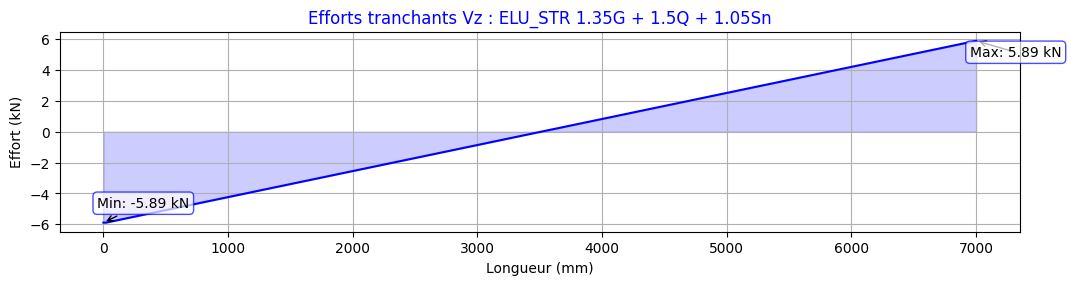

In [27]:
combi = dict_taux_max["cisaillement"]["combinaison"]
dict_combi[combi]["EF"].show_graphique_Vz(combi)

- <font color="blue" size ="4">**Contrainte de cisaillement maximale dans l'élément 2 selon Annexe B.4 de l'EN 1995**</font>

In [28]:
dict_effort_max = dict_combi[combi]["EF"].reaction_max()
# dict_effort_max = dict_combi[combi]["EF"].effort_interne_max()
V_z = max(dict_effort_max['Rz_max'][1],abs(dict_effort_max['Rz_min'][1]))
tau_2 = dalle_ELU.tau_2_max(V_z)
display(Latex(tau_2[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="4">**Capacité résistante en cisaillement de l'élément 2**</font>

In [29]:
fmd = dict_combi[combi]["planche haute"]["cisaillement"].f_v_d(action, "Fondamentales")
display(Latex(fmd[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="4">**Taux de travail en cisaillement maximal dans l'élément 2**</font>

In [30]:
taux_cisaillement = dict_combi[combi]["planche haute"]["cisaillement"].taux_tau_d()
display(Latex(taux_cisaillement[0]))

<IPython.core.display.Latex object>

## 6. Flexion selon l'axe y
----

#### 6.1. Flexion dans la planche haute selon l'axe y

- <font color="blue" size ="4">**Diagramme du moment My**</font>

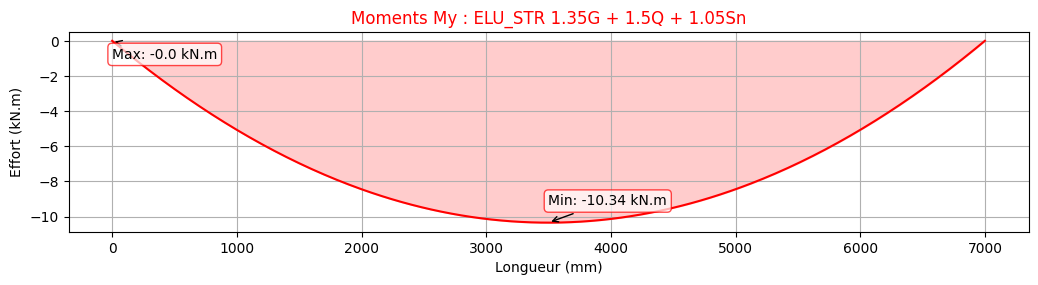

In [31]:
combi = dict_taux_max["flexion"]["combinaison"]
dict_combi[combi]["EF"].show_graphique_My(combi)

- <font color="blue" size ="4">**Contrainte de flexion dans l'élément 2 le long de l'axe y selon Annexe B.3 de l'EN 1995**</font>

In [32]:
dict_effort_max = dict_combi[combi]["EF"].effort_interne_max()
M_y = max(dict_effort_max['My_max']['Effort'],abs(dict_effort_max['My_min']['Effort']))
sigma_mi = dalle_ELU.sigma_mi(M_y, beam=2)

display(Latex(sigma_mi[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="4">**Résistance de calcul en flexion élément 2**</font>

In [33]:
fmd = dict_combi[combi]["planche haute"]["flexion"].f_m_d(action, "Fondamentales")
display(Latex(fmd[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="4">**Contrainte de compression/traction dans l'élément 2 parallèle au fil selon Annexe B.3 de l'EN 1995**</font>

In [34]:
sigma_i = dalle_ELU.sigma_i(M_y, beam=2)
display(Latex(sigma_i[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="4">**Taux de travail en compression/traction + flexion de l'élément 2**</font>

In [35]:
dict_combi[combi]["planche haute"]["flexion"].sigma_m_rd = {'y': sigma_mi[1], 'z': 0 * si.MPa}
traction=None
compression=None
if sigma_i[1] < 0:
    dict_combi[combi]["planche haute"]["compression"] = EC5_Ele.Compression._from_parent_class(barre2,  lo_y=flambement_y, lo_z=flambement_z, type_appuis= "Rotule - Rotule")
    fc0d = dict_combi[combi]["planche haute"]["compression"].f_c_0_d(action, "Fondamentales")
    dict_combi[combi]["planche haute"]["compression"].sigma_c_0_rd = abs(sigma_i[1])
    taux_compression = dict_combi[combi]["planche haute"]["compression"].taux_c_0_d()
    compression=dict_combi[combi]["planche haute"]["compression"]
    print("Barre en compression + flexion")
    display(Latex(taux_compression[0]))
else:
    dict_combi[combi]["planche haute"]["traction"] = EC5_Ele.Traction._from_parent_class(barre2)
    ft0d = dict_combi[combi]["planche haute"]["traction"].f_t_0_d(action, "Fondamentales")
    dict_combi[combi]["planche haute"]["traction"].sigma_t_0_rd = sigma_i[1]
    taux_traction = dict_combi[combi]["planche haute"]["traction"].taux_t_0_d()
    traction=dict_combi[combi]["planche haute"]["traction"]
    print("Barre en traction + flexion")
    display(Latex(taux_traction[0]))
taux_flexion = dict_combi[combi]["planche haute"]["flexion"].taux_m_d(compression=compression, traction=traction)
display(Latex(taux_flexion[0]))

Barre en compression + flexion


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### 6.2. Flexion dans la planche intermédiaire selon l'axe y

- <font color="blue" size ="4">**Contrainte de flexion dans l'élément 3 le long de l'axe y selon Annexe B.3 de l'EN 1995**</font>

In [36]:
dict_effort_max = dict_combi[combi]["EF"].effort_interne_max()
M_y = max(dict_effort_max['My_max']['Effort'],abs(dict_effort_max['My_min']['Effort']))
sigma_mi = dalle_ELU.sigma_mi(M_y, beam=3)

display(Latex(sigma_mi[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="4">**Résistance de calcul en flexion de l'élément 3**</font>

In [37]:
fmd = dict_combi[combi]["planche intermédiaire/basse"]["flexion"].f_m_d(action, "Fondamentales")
display(Latex(fmd[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="4">**Contrainte de compression/traction dans l'élément 3 parallèle au fil selon Annexe B.3 de l'EN 1995**</font>

In [38]:
sigma_i = dalle_ELU.sigma_i(M_y, beam=3)
display(Latex(sigma_i[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="4">**Taux de travail en compression/traction + flexion de l'élément 3**</font>

In [39]:
dict_combi[combi]["planche intermédiaire/basse"]["flexion"].sigma_m_rd = {'y': sigma_mi[1], 'z': 0 * si.MPa}
traction=None
compression=None

if sigma_i[1] < 0:
    dict_combi[combi]["planche intermédiaire/basse"]["compression"] = EC5_Ele.Compression._from_parent_class(barre2,  lo_y=flambement_y, lo_z=flambement_z, type_appuis= "Rotule - Rotule")
    fc0d = dict_combi[combi]["planche intermédiaire/basse"]["compression"].f_c_0_d(action, "Fondamentales")
    dict_combi[combi]["planche intermédiaire/basse"]["compression"].sigma_c_0_rd = abs(sigma_i[1])
    taux_compression = dict_combi[combi]["planche intermédiaire/basse"]["compression"].taux_c_0_d()
    compression=dict_combi[combi]["planche intermédiaire/basse"]["compression"]
    print("Barre en compression + flexion")
    display(Latex(taux_compression[0]))
else:
    dict_combi[combi]["planche intermédiaire/basse"]["traction"] = EC5_Ele.Traction._from_parent_class(barre2)
    ft0d = dict_combi[combi]["planche intermédiaire/basse"]["traction"].f_t_0_d(action, "Fondamentales")
    dict_combi[combi]["planche intermédiaire/basse"]["traction"].sigma_t_0_rd = sigma_i[1]
    taux_traction = dict_combi[combi]["planche intermédiaire/basse"]["traction"].taux_t_0_d()
    traction=dict_combi[combi]["planche intermédiaire/basse"]["traction"]
    print("Barre en traction + flexion")
    display(Latex(taux_traction[0]))
taux_flexion = dict_combi[combi]["planche intermédiaire/basse"]["flexion"].taux_m_d(compression=compression, traction=traction)
display(Latex(taux_flexion[0]))

Barre en traction + flexion


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## 7. ELS
----

- <font color="blue" size ="4">**Flèche instantanée (Q)**</font>

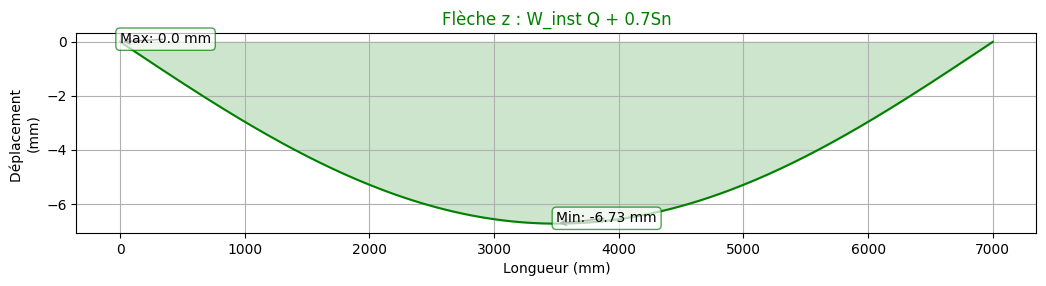

In [40]:
combi = dict_taux_max["Winst(Q)"]["combinaison"]
dict_combi[combi]["EF"].show_graphique_fleche(combi)

In [41]:
dictUMinMax = dict_combi[combi]["EF"].deplacement_max()
Ed_WinstQ = max(dictUMinMax['Uz_max'][0],abs(dictUMinMax['Uz_min'][1]))

- <font color="blue" size ="4">**Flèche nette finale**</font>

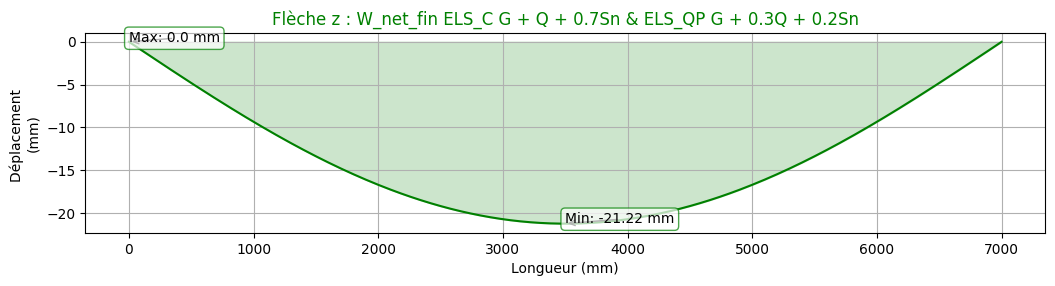

In [42]:
combi = dict_taux_max["Wnet,fin"]["combinaison"]
dict_combi[combi]["EF"].show_graphique_fleche(combi)

- <font color="blue" size ="4">**Taux de travail ELS**</font>

In [43]:
dictUMinMax = dict_combi[combi]["EF"].deplacement_max()
Ed_Wnetfin = max(dictUMinMax['Uz_max'][0],abs(dictUMinMax['Uz_min'][1]))
fleche = barre2.fleche(long=l, Ed_WinstQ=Ed_WinstQ, Ed_Wnetfin=Ed_Wnetfin, Ed_Wfin=Ed_Wnetfin,type_ele=type_element, type_bat=type_batiment)
display(Latex(fleche[0]))

<IPython.core.display.Latex object>

## 8. Assemblage
----

- <font color="blue" size ="4">**Portance locale**</font>

In [44]:
print( "Fh,1,k :")
display(Latex(connecteur.fh1k[0]))

print( "Fh,2,k :")
display(Latex(connecteur.fh2k[0]))

Fh,1,k :


<IPython.core.display.Latex object>

Fh,2,k :


<IPython.core.display.Latex object>

- <font color="blue" size ="4">**Nombre efficace**</font>

In [45]:
display(Latex(nef[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="4">**Résistance en cisaillement caractéristique**</font>

In [46]:
display(Latex(FvRk[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="4">**Charge à reprendre par organe d'assemblage selon Annexe B.5 de l'EN 1995**</font>

In [47]:
F_i = dalle_ELU.F_i(V_z, connecteur=2)
display(Latex(F_i[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="4">**Résistance de calcul connecteur**</font>

In [48]:
display(Latex(connecteur.F_Rd(FvRk[1].value*10**-3)[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="4">**Taux de travail connecteur**</font>

In [49]:
display(Latex(connecteur.taux_cisaillement(Fv_Ed = F_i[1].value*10**-3)[0]))

<IPython.core.display.Latex object>

In [50]:
app.exit()

NameError: name 'app' is not defined

In [ ]:
# yG = dalle.distance_ai[1] + barre2.h_calcul/2
# yG = yG.value *10**3
# y = [h for h in range(0, int(barre2.h_calcul.value*10**3)+20, 20)]

# sigma_m = []
# tau = []
# My = M_y.value*10**3
# Vz = V_z.value
# E_mean_fin_3 = dalle.beam[2].E_mean_fin.value *10**-6
# ei_eff = dalle.EI_eff[1].value *10**6
# beam_2 = dalle.beam[1]
# beam_3 = dalle.beam[2]
# h3 = (dalle.beam[1].h_calcul.value/2 - dalle.recouvrement[1].value- dalle.beam[2].h_calcul.value/2)*10**3
# print(h3, dalle.beam[1].h_calcul.value, dalle.recouvrement[1].value, dalle.beam[2].h_calcul.value)

# tau_value = 0
# for h in y:
#     for yi in y:
#         for index, beam in enumerate(dalle.beam):
#             if beam_2.h_calcul.value *10**3 <=yi:
#                 if beam is not None:
#                     gamma_i = dalle.gamma_i["gamma 2"]
#                     E_mean_fin = beam_2.E_mean_fin.value *10**-6
#                     b = dalle.beam[1].b_calcul.value *10**3
#                     h = dalle.beam[1].h_calcul.value *10**3
#                     distance_ai = dalle.distance_ai[1].value *10**3
#                     h_z = h
#                     for yi in y:
#                         if yi < h:
#                             h_z = yi
#                         else:
#                             h_z = h
                        
#                         tau_2 = (Vz*gamma_i*E_mean_fin*b*h_z*distance_ai)/(ei_eff*b) 
#                         tau_value = tau_value + tau_2
#                         print (tau_value, h_z, gamma_i)
#             elif h3 <=yi:
#                 if beam is not None:
#                     gamma_i = dalle.gamma_i["gamma 3"][1]
#                     print(gamma_i)
#                     E_mean_fin = beam_3.E_mean_fin.value *10**-6
#                     b = dalle.beam[2].b_calcul.value *10**3
#                     h = dalle.beam[2].h_calcul.value *10**3
#                     distance_ai = dalle.distance_ai[2].value *10**3
#                     h_z = h+h3
#                     for yi in y:
#                         if yi < h_z:
#                             h_z = yi
#                         else:
#                             h_z = h_z
#                         print(Vz,gamma_i,E_mean_fin,b,h_z,distance_ai,ei_eff,b)
#                         tau_3 = (Vz*gamma_i*E_mean_fin*b*h_z*distance_ai)/(ei_eff*b) 
#                         tau_value = tau_value + tau_3
#                         print (tau_value, h_z, gamma_i)
#     tau.append(tau_value)
        
# for h in y:
#     v = yG - h
#     sigma_m.append(My * E_mean_fin_3 * v / ei_eff)

# plt.figure(figsize=(14,7))
# plt.title("Contrainte de flexion Sigma,m")
# plt.xlabel("Contrainte en MPa")
# plt.ylabel("Hauteur de la poutre en mm")

# plt.plot(sigma_m, y)
# plt.plot(tau, y)

# plt.plot([0] * len(y), y, color='red')
# x = np.arange(int(min(sigma_m))-10, int(max(sigma_m))+10, step=2)
# plt.plot(x, [yG] * len(x), color='red')

# plt.grid(True)
# plt.xticks(np.arange(int(min(sigma_m))-5, int(max(sigma_m))+5, step=2))
# plt.yticks(np.arange(int(min(y)), int(max(y)+10), step=10))

# if abs(int(min(sigma_m))) > abs(int(max(sigma_m))):
#     sigma_max  = round(min(sigma_m),2)
# else:
#     sigma_max = round(max(sigma_m),2)
# if abs(int(min(tau))) > abs(int(max(tau))):
#     tau_max  = round(min(tau),2)
# else:
#     tau_max = round(max(tau),2)
# plt.text(sigma_max, int(yG) +10, f"yG: {round(yG,1)}mm", color="red")
# plt.text(sigma_max, int(barre2.h_calcul.value*10**3 / 2 - 50), f"contrainte max flexion: \n{sigma_max} MPa", color="blue")
# plt.text(tau_max, int(barre2.h_calcul.value*10**3 / 2 - 50), f"contrainte max cisaillement : \n{tau_max} MPa", color="orange")
# plt.show()